# 소프트맥스회귀 (MNIST 데이터셋)

- MNIST는 인공지능 연구의 권위자 LeCun교수가 만든 데이터 셋
- 딥러닝을 공부할 때 반드시 거쳐야할 Hello, World같은 존재
- MNIST는 60,000개의 트레이닝 셋과 10,000개의 테스트 셋으로 이루어져 있고 이중 트레이닝 셋을 학습데이터로 사용하고 테스트 셋을 신경망을 검증하는 데에 사용한다.

## #01. 패키지 및 그래프 초기화

In [44]:
import sys
sys.path.append("../../")
import helper

from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# (신규) 예제에서 사용할 데이터셋을 다운로드 받기 위한 함수
from tensorflow.keras.datasets.mnist import load_data

## #02. 데이터 준비

In [45]:
(x_train, y_train), (x_test, y_test) = load_data(path = 'mnist.npz')
print(f"훈련 데이터 {x_train.shape} 레이블 {y_train.shape}")
print(f"검증 데이터 {x_train.shape} 레이블 {y_train.shape}")

훈련 데이터 (60000, 28, 28) 레이블 (60000,)
검증 데이터 (60000, 28, 28) 레이블 (60000,)


> 단색은 3차원 데이터, 컬러 이미지는 4차원 데이터, 

## #03. 데이터 전처리

- 결측치 등의 데이터 이상점이 없는 예제 데이터이므로 생략

## #04. 탐색적 데이터 분석

### 임의의 샘플 데이터 확인

In [46]:
# print(x_train[0])
print(x_train[1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 25

In [47]:
# 길이 확인
np.max(x_train[1])

255

In [48]:
for i in x_train[1]:
    for j in i:
        print("%03d" % j, end="")
    print()

000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000051159253159050000000000000000000000000
000000000000000000000000000000000000000000048238252252252237000000000000000000000000
000000000000000000000000000000000000000054227253252239233252057006000000000000000000
000000000000000000000000000000000010060224252253252202084252253122000000000000000000
000000000000000000000000000000000163252252252253252252096189253167000000000000000000
000000000000000000000000000000051238253253190114253228047079255168000000000000000000
000000000000000000000000000048238252252179012075121021000000253243050000000000000000
00000000000000000000000003816525323320808400000000000000000025325

In [49]:
y_train[1]

0

### 데이터 그려보기

`mnist 데이터셋`은 0~9까지 가로 28px, 세로 28px 크기의 이미지 60000장 + 10000장 데이터.

글자를 표현하는 간단한 이미지이므로 배경색을 단색으로 처리하고 글자가 표시되는 영역의 색상을 노란색으로 표현.

색상값은 0~255 사이의 10진 정수.

그러므로 이미지 데이터들은 이미지 픽셀 크기 만큼의 2차 배열의 각 원소가 색상값을 의미하는 숫자로 구성된 데이터로 표현가능.

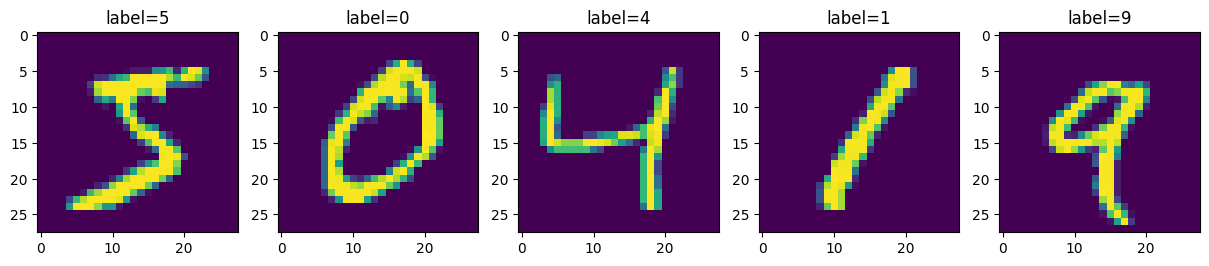

In [50]:
fig, ax = plt.subplots(1,5,figsize=(15,3), dpi=100)

for i in range(0,len(ax)):
    train = x_train[i]
    label = y_train[i]
    ax[i].imshow(train)
    ax[i].set_title("label=%d" % label)

plt.show()
plt.close()

## #05. 데이터셋 분할

### 랜덤시드 고정

In [51]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

- 처음부터 데이터 셋이 구분되어 있었으므로 생략

### 훈련 데이터와 검증 데이터로 분할

- 처음부터 데이터 셋이 구분되어 있었으므로 생략

### 레이블에 대한 one-hot-encoding

In [52]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot)
print("-"*50)
print(y_test_one_hot)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
--------------------------------------------------
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 훈련, 검증용 독립변수(이미지)의 차수 재설정

훈련 데이터의 shape가 (60000, 28, 28)라는 것은 가로 28, 세로 28 크기의 이미지가 60000장 이라는 의미.

즉, 28x28의 이차배열이 6만개가 존재하는 의미

즉, 60000개의 2차원 배열을 학습해야 하는 것 보다 60000개의 784(28*28)개의 원소를 갖는 1차원 배열을 학습하는 것이 학습 효율이 더 좋다.

> 3차원 보다는 2차원이, 2차원 데이터보다 1차원 데이터가 처리하기 편함.

In [53]:
x_train.shape

(60000, 28, 28)

In [54]:
# x_train.shape[0] : 데이터 세트의 샘플 수
# x_train.shape[1] : 각 이미지의 세로 픽셀 수
# x_train.shape[2] : 각 이미지의 가로 픽셀 수
# 각 데이터 세트를 이차원 배열로 재구성
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_train_reshape.shape}')
print(x_train_reshape[0])

훈련 데이터 (60000, 784) / 검증 데이터 (60000, 784)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255
 247 127   0   0   0   0   0   0   0   0   0   0   0   0  30  36  94 154
 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0   0   0
   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82
  82  56  39   0   0   0   0   0   0   0   0   0   0   0   0  18 219 253
 253 253 

### 이미지 데이터 정규화

각 픽셀의 색상값은 0~255 사이의 값을 갖는다.

그러므로 색상값을 255로 나누면 0~1 사이의 범위를 갖도록 데이터 정규화가 수행된다.

>MinMax 스케일을 하되 import 대신 범위가 0~255이므로 (/255)실행

In [55]:
x_train_normal = x_train_reshape / 255
x_test_normal = x_test_reshape / 255

print(len(x_train_normal[0]))
x_train_normal[0]

784


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## #06. 모델 개발

### 모델 정의

> relu, sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense(출력 수) 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [56]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(len(x_train_normal[0]), )))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  #0~9 값 중 하나이므로 출력 수는 10
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               200960    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [57]:
result = model.fit(x_train_normal, y_train_one_hot, epochs=500, validation_data=(x_test_normal, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2055 - acc: 0.9384 - val_loss: 0.1081 - val_acc: 0.9684 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0864 - acc: 0.9731 - val_loss: 0.0863 - val_acc: 0.9739 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0589 - acc: 0.9811 - val_loss: 0.0811 - val_acc: 0.9751 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0440 - acc: 0.9859 - val_loss: 0.0718 - val_acc: 0.9792 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0323 - acc: 0.9894 - val_loss: 0.0701 - val_acc: 0.9808 - lr: 0.0010
Epoch 6/500
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0296 - acc: 0.9903 - val_loss: 0.0780 - val_acc: 0.9788 - lr: 0.0010
Epoch 7/500
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0240 - acc: 0.9917 - val_l

## #07. 학습 결과 평가

### 학습 결과 시각화

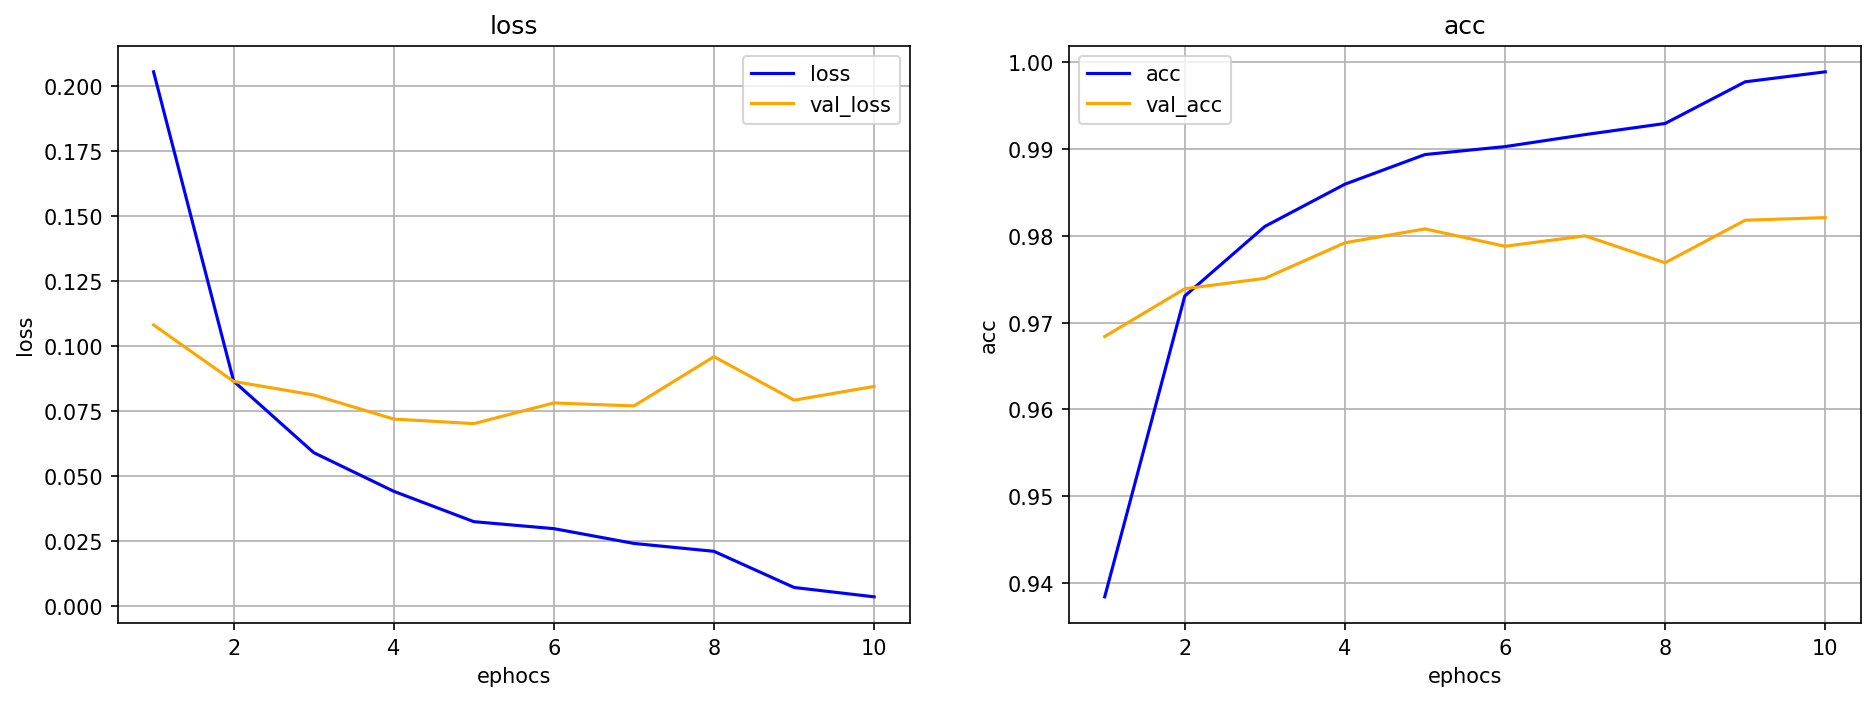

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.205502,0.938400,0.108076,0.9684,0.0010
2,0.086429,0.973067,0.086315,0.9739,0.0010
3,0.058910,0.981083,0.081099,0.9751,0.0010
4,0.044024,0.985950,0.071838,0.9792,0.0010
5,0.032335,0.989367,0.070078,0.9808,0.0010
6,0.029642,0.990283,0.078035,0.9788,0.0010
7,0.023951,0.991667,0.076893,0.9800,0.0010
8,0.020910,0.992950,0.095851,0.9769,0.0010
9,0.007002,0.997750,0.079102,0.9818,0.0005


In [58]:
helper.tf_result_plot(result)

In [59]:
evaluate1 = model.evaluate(x_train_normal, y_train_one_hot)
print("최종 훈련 손실률 : %f, 최종 훈련 정확도 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test_normal, y_test_one_hot)
print("최종 검증 손실률 : %f, 최종 검증 정확도 : %f" % (evaluate2[0], evaluate2[1]))

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0032 - acc: 0.9991
최종 훈련 손실률 : 0.003192, 최종 훈련 정확도 : 0.999100
313/313 [==============================] - 1s 2ms/step - loss: 0.0844 - acc: 0.9821
최종 검증 손실률 : 0.084401, 최종 검증 정확도 : 0.982100


## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [60]:
result = model.predict(x_test_normal)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

313/313 [==============================] - 1s 2ms/step
10000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([8.3106193e-16, 5.8487798e-12, 2.5177541e-10, 1.2546688e-11,
       4.5242785e-12, 5.7615186e-16, 6.5255089e-19, 1.0000000e+00,
       2.3724836e-15, 3.2662577e-12], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [61]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

### 데이터 비교

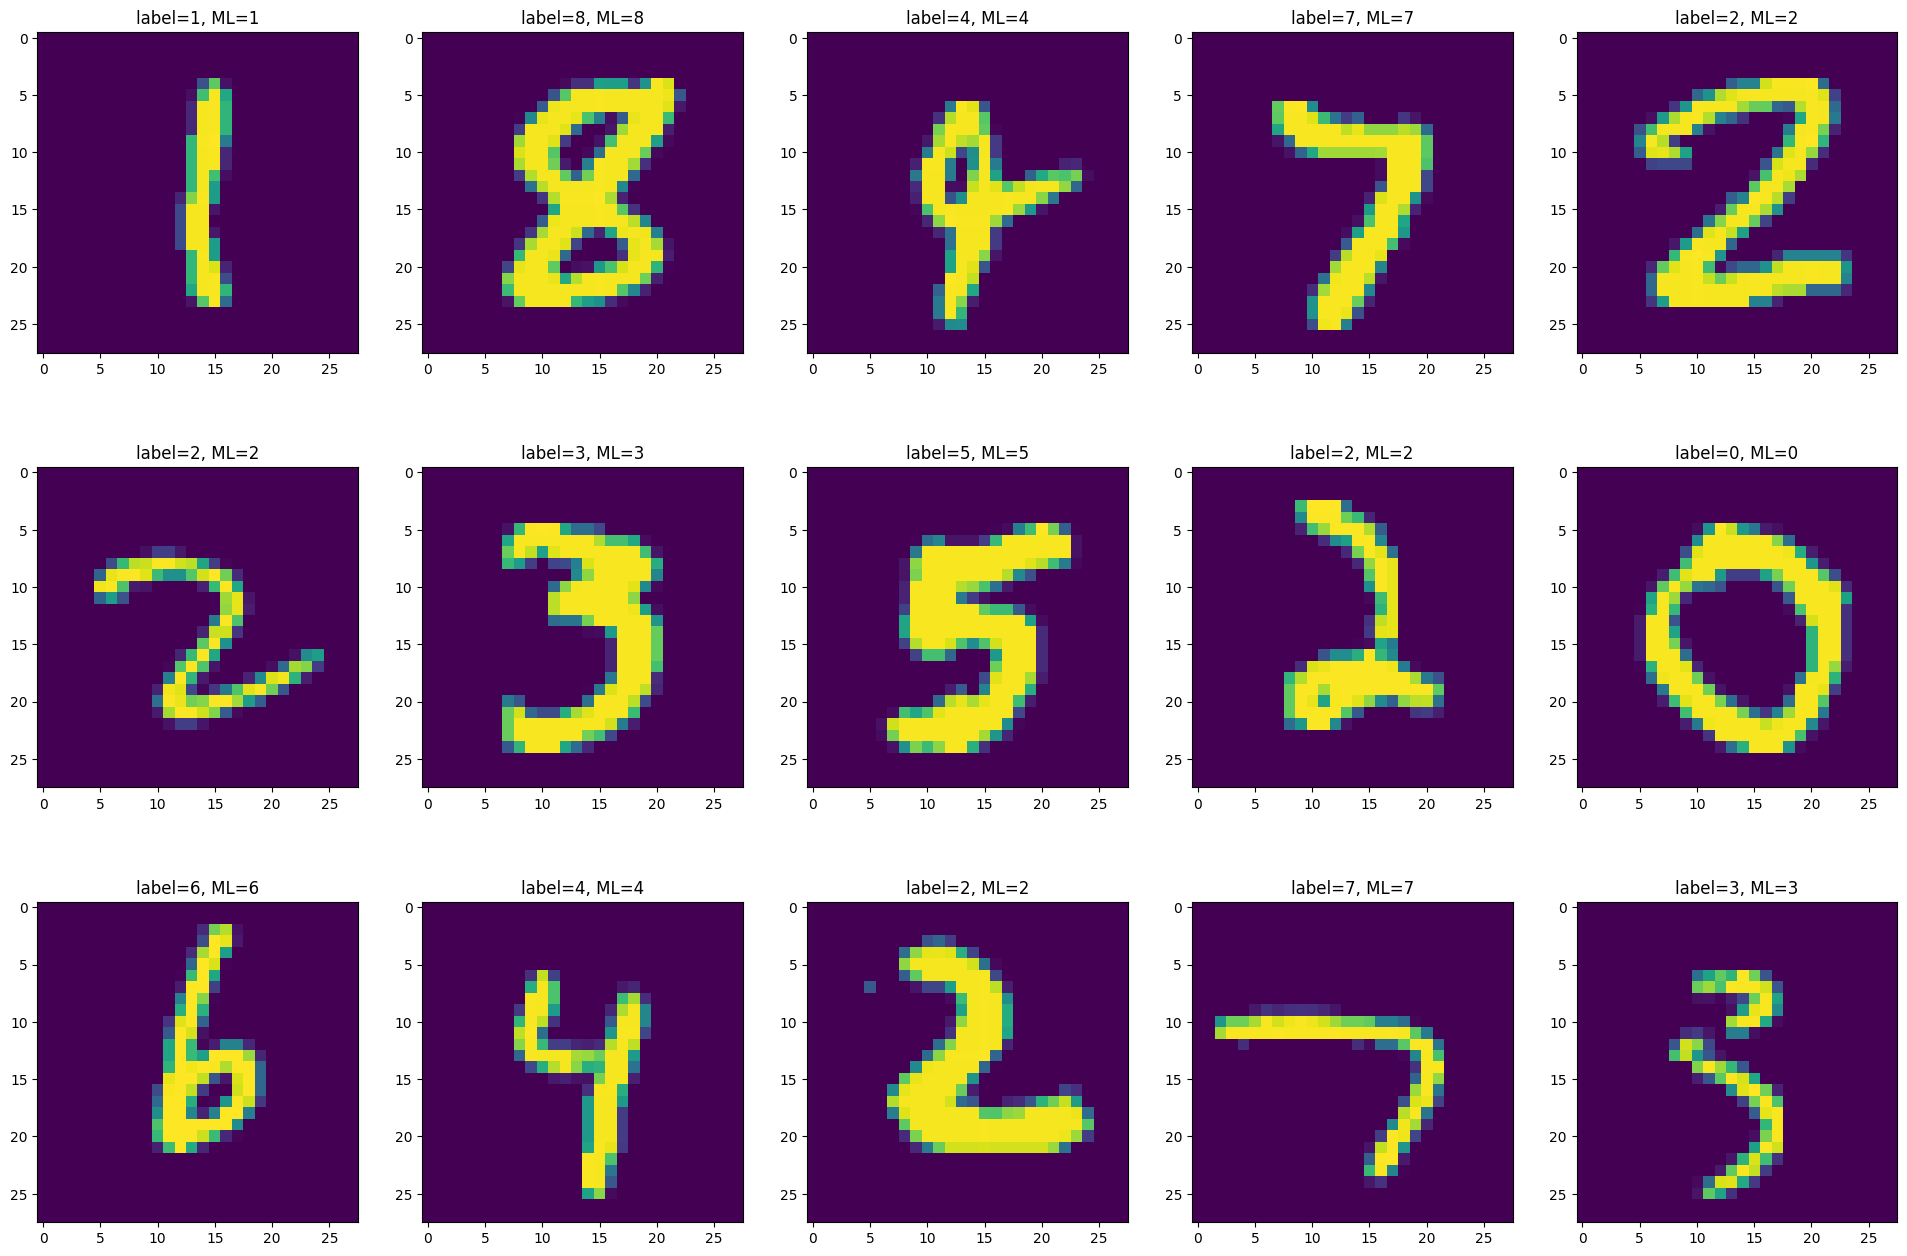

In [62]:
row = 3
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row*col
length = len(y_test)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_test[k]
    label = y_test[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title("label=%d, ML=%d" % (label, arg_result[k]))

plt.show()
plt.close()

### 직접 작성한 손글씨 이미지 불러오기

#### 이미지 로드를 위한 패키지

In [74]:
from PIL import Image

#### 첫 번째 이미지

In [75]:
img2 = Image.open('res/손글씨2.jpg')
img2

#### 두 번째 이미지

In [76]:
img3 = Image.open('res/손글씨3.jpg')
img3

#### 이미지를 grayscale로 변환

`일반 이미지는 R,G,B 세가지 색상`의 조합으로 존재하기 때문에 (색상수x(가로크기x세로크기))의 `3차원 데이터`임

이미지를 `grayscale(흑백이미지)`로 변경하면 `색상수가 1가지`로 줄어들기 때문에 (가로크기x세로크기)의 `2차원 데이터로 압축`됨

##### 첫 번째 이미지의 흑백 변환

In [77]:
img2_gray = img2.convert('L')
img2_gray

##### 두 번째 이미지의 흑백 변환

In [78]:
img3_gray = img3.convert('L')
img3_gray

##### 이미지를 배열로 변환하기

In [79]:
img2_array = np.array(img2_gray)
img3_array = np.array(img3_gray)
img2_array.shape, img3_array.shape

((28, 28), (28, 28))

##### 독립변수 데이터 구성하기

In [80]:
# 두 개의 이미지를 배열로 묶음
myx = np.array([img2_array, img3_array])

# 차원을 하나 줄여서 2차원 배열로 변환 --> 2x28x28 --> 2x784
myx_reshape = myx.reshape(myx.shape[0], myx.shape[1] * myx.shape[2])

# 데이터 표준화
myx_normal = myx_reshape / 255

myx_normal.shape

(2, 784)

#### 종속변수 데이터 구성하기

In [81]:
myy = np.array([2, 3])

#### 구성한 데이터를 학습모델에 적용

In [82]:
result = model.predict(myx_normal)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

1/1 [==============================] - 0s 35ms/step
2개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([6.3424011e-07, 5.0572160e-04, 9.5176506e-01, 1.5191664e-04,
       1.2586321e-08, 7.4649166e-04, 1.9864816e-05, 8.3433761e-06,
       4.6801809e-02, 1.3278530e-07], dtype=float32)

#### 산출된 값을 통해 판별 결과 생성

In [83]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([2, 3], dtype=int64)

#### 결과 출력

IndexError: index 2 is out of bounds for axis 0 with size 2

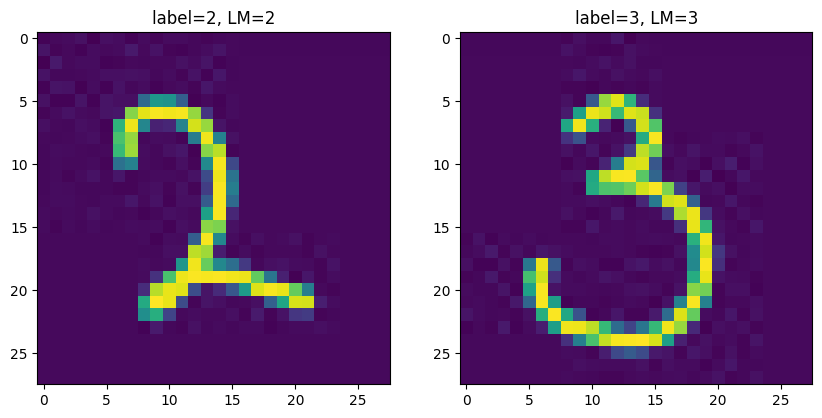

In [84]:
col = 2
fig, ax = plt.subplots(1, col, figsize=(10, 5), dpi=100)

size = row*col
length = len(y_test)

for i in range(0, size):
    train = myx[i]
    label = myy[i]
    ax[i].imshow(train)
    ax[i].set_title("label=%d, LM=%d" % (label, arg_result[i]))

plt.show()
plt.close()